In [ ]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from IPython.display import display, SVG, clear_output
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import chess
import torch
import time
from src.leela_data import Lc0Loader, Lc0TeacherDataset
from src.util import save_gif
from src.train import train
from src.leela_cnn import LeelaCNN

Scanning directory for game data chunks...


Files scanned: 1 files [00:00, 2526.69 files/s]


1 matching files.
Done!


Filling shuffle buffer: 100%|██████████| 128/128 [00:07<00:00, 16.59it/s]


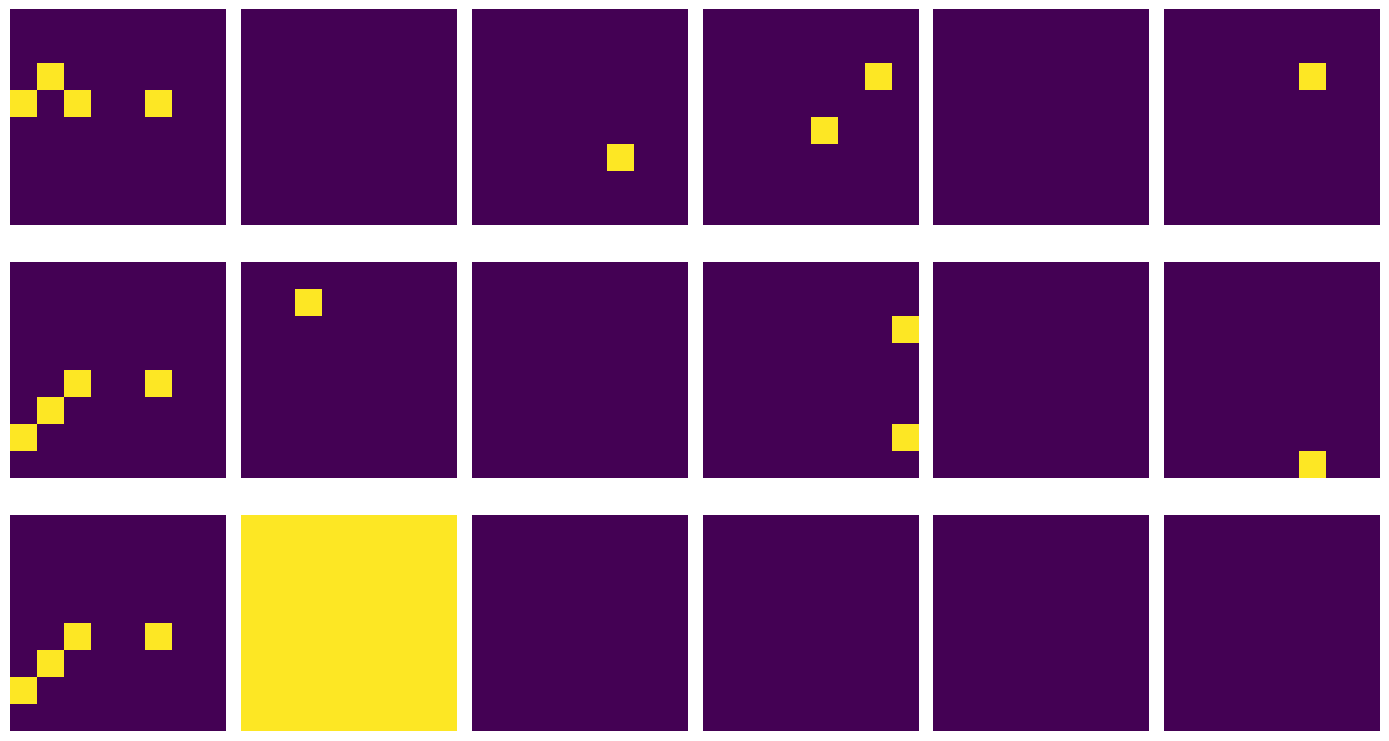

In [10]:

chunk_dir = '../data/small'
files = list(Path(chunk_dir).glob("*.gz"))
dataset = Lc0TeacherDataset(
    lc0_loader=Lc0Loader(chunk_dir=Path(chunk_dir))
)
board, mask, policy, value = next(iter(dataset))
fig, axes = plt.subplots(3, 6, figsize=(14, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(
        board[i].numpy(),
        # cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
class Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.policy_loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        self.value_loss_fn = torch.nn.L1Loss(reduction='mean')

    def forward(
        self,
        mask: torch.Tensor,
        policy_pred: torch.Tensor,
        value_pred: torch.Tensor,
        policy_target: torch.Tensor,
        value_target: torch.Tensor,
    ):
        zeros = torch.zeros((policy_pred.shape)).to(mask.device)
        policy_pred = torch.where(mask, policy_pred, zeros)
        policy_target = torch.where(mask, policy_target, zeros)
        policy_loss = self.policy_loss_fn(policy_pred, policy_target)
        value_loss = self.value_loss_fn(value_pred.squeeze(), value_target.squeeze())
        total_loss = policy_loss + value_loss
        return total_loss, policy_loss, value_loss

In [12]:
loss = Loss()

In [15]:
model = LeelaCNN(
    block_count=10,
    filter_count=128,
)
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

train(
    model_name='LeelaCNN v0.1',
    model=model,
    loss_fn=Loss(),
    optimizer=optim,
    scheduler=scheduler,
    train_set=dataset,
    val_set=dataset,
    batch_size=256,
    num_workers=1,
    epochs=10,
    seed=42,
)


Scanning directory for game data chunks...


Files scanned: 1 files [00:00, 2173.21 files/s]


1 matching files.
Done!


Filling shuffle buffer:  34%|███▎      | 43/128 [00:02<00:05, 16.96it/s]Process SpawnProcess-5:

Process SpawnProcess-2:
Process SpawnProcess-1:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.14/3.14.0/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/process.py", line 320, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.14/3.14.0/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/max/ml/chesshacks-training/notebooks/../src/new_data_pipeline.py", line 208, in data_worker
    current_file = next(file_gen)
  File "/Users/max/ml/chesshacks-training/notebooks/../src/new_data_pipeline.py", line 26, in file_generator
    yield deflate.gzip_decompress(file.read_bytes())
          ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
Traceback (most

KeyboardInterrupt: 